# Load Data

In [53]:
import pandas as pd
import numpy as np
from scipy import stats

choice_data_dprime_threeRounds=np.load('data_dprime_cleaned.npy')
cd=np.reshape(choice_data_dprime_threeRounds,(1161,1))
# choice_data_dprime_threeRounds=(choice_data_dprime_threeRounds-np.mean(choice_data_dprime_threeRounds))/np.std(choice_data_dprime_threeRounds)
print('averages across conditions:\n baseline:    unpopular:     popular:')
print(np.mean(np.mean(choice_data_dprime_threeRounds,axis=0),axis=1))
print('')
print('')
print('std dev baseline')
print(np.std((choice_data_dprime_threeRounds[:,0,0]+choice_data_dprime_threeRounds[:,0,1]+choice_data_dprime_threeRounds[:,0,2])/3.0))
print('std dev high')
print(np.std((choice_data_dprime_threeRounds[:,2,0]+choice_data_dprime_threeRounds[:,2,1]+choice_data_dprime_threeRounds[:,2,2])/3.0))
print('std dev low')
print(np.std((choice_data_dprime_threeRounds[:,1,0]+choice_data_dprime_threeRounds[:,1,1]+choice_data_dprime_threeRounds[:,1,2])/3.0))
order=np.load('order_variable.npy')
print(order)
print('length of order variable: {}'.format(len(order)))
likeable_threegroups=np.load('likeable_subs_allthree.npy')
likeable_threegroups=likeable_threegroups+1 # rescale to 0,1,2 encoding 


bl=(choice_data_dprime_threeRounds[:,0,0]+choice_data_dprime_threeRounds[:,0,1]+choice_data_dprime_threeRounds[:,0,2])/3.0
unpop=(choice_data_dprime_threeRounds[:,1,0]+choice_data_dprime_threeRounds[:,1,1]+choice_data_dprime_threeRounds[:,1,2])/3.0
pop=(choice_data_dprime_threeRounds[:,2,0]+choice_data_dprime_threeRounds[:,2,1]+choice_data_dprime_threeRounds[:,2,2])/3.0
x=pd.DataFrame(bl)
x=x.rename(columns={0:'bl'})
x['unpop']=unpop
x['pop']=pop
x['grouping']=likeable_threegroups
print('group means:')
print(x.groupby(['grouping']).mean())
print('')
print('group SDs')
print(x.groupby(['grouping']).std())
print('')


#just subjects who know peers
lik_red=np.load('likeable_subs_allthree_known.npy')
lik_red=lik_red+1
choice_data=np.load('data_justknown_subs.npy')
order_red=np.load('order_variable_fixed.npy')
print('Number subjects: {}'.format(len(choice_data)))

averages across conditions:
 baseline:    unpopular:     popular:
[1.81786053 2.09793151 2.22048874]


std dev baseline
0.8488439348153587
std dev high
1.0321188345288606
std dev low
1.0517780084467956
[1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0
 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0
 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1]
length of order variable: 129
group means:
                bl     unpop       pop
grouping                              
0         1.605275  2.222533  1.674533
1         1.691532  2.268019  2.208512
2         1.977162  1.941533  2.424551

group SDs
                bl     unpop       pop
grouping                              
0         0.930878  1.067887  1.125006
1         0.791050  0.924566  1.007628
2         0.844172  1.122857  0.962975

Number subjects: 96


In [86]:
print(np.sum(likeable_binary))
print(len([x for x in likeable_no_equals if x==0]))
print(len([x for x in likeable_no_negs if x==0]))
print(64+23+42)

64
23
42
129


# Calculate scaled priors

In [66]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

ySD=np.std(choice_data_dprime_threeRounds)
yMean=np.mean(choice_data_dprime_threeRounds)
gammas, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
bl_sd=1/((ySD*5)**2)
print(bl_sd)
noise=[ySD/100,ySD*10]
print(noise)
print(gammas)
print(rate)




0.02600779278351543
[0.012401615076976711, 12.40161507697671]
1.2831955546343297
0.45670753829487126


In [67]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

ySD=np.std(choice_data)
yMean=np.mean(choice_data)
gammas, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
bl_sd=1/((ySD*5)**2)
print(bl_sd)
noise=[ySD/100,ySD*10]
print(noise)
print(gammas)
print(rate)




0.02658058710090894
[0.012267263981868021, 12.267263981868021]
1.2831955546343297
0.46170939999810057


In [21]:
print(len(likeable_no_equals))
print(len(choice_data_dprime_threeRounds_r))

87
87


# Model: condition, subject, group & interaction of group and condition

#### For model below, i=condition, j=subject, k=block,g=group

$data_{i,k,j} \sim \mathcal{N}(theta_{i,k,j},noise)$

$noise \sim U(0.01,10)$ Error term

$\theta_{i,k,j}= baseline+subjectIntercept_{j}+groupEffect_{g}+conditionEffect_{i}+Interaction_{g,i}$

$subjectIntercept_{j} \sim \mathcal{N}(\mu_{data},\sigma_{subject})$

$baseline \sim \mathcal{N}(0,5)$

$\sigma_{subject} \sim U(0,\sigma_{S})$

$ConditionEffect \sim \mathcal{N}(0,\sigma_{W})$

$groupEffect \sim \mathcal{N}(0,\sigma_{B})$

$Interaction \sim \mathcal{N}(0,\sigma_{BxW})$

$\sigma_{all} \sim \mathcal{G}(1.28,0.56)$


 # Status value model

In [50]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> order[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  
  //order variable
  vector[2] orderv;
  
  
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (order[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+orderv[1];
            theta_popular[k] =  a0+aS[k]+aCondition[2]+orderv[1];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+orderv[1];}
        else if (order[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+orderv[2];
            theta_popular[k] = a0+aS[k]+aCondition[2]+orderv[2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+orderv[2];
        }
        }
        
    
}
model {    
    
    
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    aCondition ~ normal(0,1);
    orderv ~normal(0,1);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.10);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds,#choice data
              'NxConditions':3,
              'NxSubjects':129,
              'NxBlocks':3,
              'order':order
              
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1c03e56d2040ce7e170ffd327eca1d82 NOW.


In [17]:
print(fit_3dprime_interaction_full)

Inference for Stan model: anon_model_e562e1b3389b1c896d820fc0c4ef4183.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd    2.5%    25%    50%     75%  97.5%  n_eff   Rhat
aS[1]                  -0.33  3.9e-3   0.32   -0.94  -0.53  -0.32   -0.11   0.28   6493    1.0
aS[2]                   0.71  3.8e-3   0.32    0.08    0.5   0.71    0.92   1.34   6719    1.0
aS[3]                  -0.21  3.7e-3   0.31   -0.82  -0.42  -0.21 -1.7e-4   0.41   7270    1.0
aS[4]                   0.27  3.8e-3   0.31   -0.32   0.06   0.28    0.49   0.88   6756    1.0
aS[5]                   1.13  3.6e-3   0.31    0.53   0.92   1.13    1.35   1.75   7397    1.0
aS[6]                   -0.2  3.8e-3   0.33   -0.84  -0.41   -0.2    0.02   0.43   7275    1.0
aS[7]                   0.95  3.7e-3    0.3    0.36   0.74   0.95    1.15   1.54   6615    1.0
aS[8]                   0.73  3.9e-3   0.31    0.12

# Status model with subjects who knew peers (n=96)

In [54]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> order[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  
  //order variable
  vector[2] orderv;
  
  
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (order[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+orderv[1];
            theta_popular[k] =  a0+aS[k]+aCondition[2]+orderv[1];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+orderv[1];}
        else if (order[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+orderv[2];
            theta_popular[k] = a0+aS[k]+aCondition[2]+orderv[2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+orderv[2];
        }
        }
        
    
}
model {    
    
    
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    aCondition ~ normal(0,1);
    orderv ~normal(0,1);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.10);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data,#choice data
              'NxConditions':3,
              'NxSubjects':96,
              'NxBlocks':3,
              'order':order_red
              
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n_red = StanModel(model_code=model_input_n)
fit_3dprime_interaction_red = model_fit_n_red.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1c03e56d2040ce7e170ffd327eca1d82 NOW.


# Individual value model

In [23]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=2> liks[NxSubjects];
    int<lower=0,upper=1> order[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  vector[3] aGroup;
  matrix[NxConditions,3] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  
  //order variable
  vector[2] orderv;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (order[k]==0){
            if (liks[k]==0){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1]+orderv[1];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1]+orderv[1];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1]+orderv[1];
                }
            else if (liks[k]==1){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2]+orderv[1];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2]+orderv[1];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2]+orderv[1];
            }
            else if (liks[k]==2){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[3]+aInteraction[1,3]+orderv[1];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[3]+aInteraction[2,3]+orderv[1];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[3]+aInteraction[3,3]+orderv[1];
            }
        }
        else if (order[k]==1){
            if (liks[k]==0){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1]+orderv[2];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1]+orderv[2];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1]+orderv[2];
                }
            else if (liks[k]==1){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2]+orderv[2];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2]+orderv[2];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2]+orderv[2];
            }
            else if (liks[k]==2){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[3]+aInteraction[1,3]+orderv[2];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[3]+aInteraction[2,3]+orderv[2];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[3]+aInteraction[3,3]+orderv[2];
        
        }}}
    
}
model {    
    
    
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
 
    aCondition ~ normal(0,1);
    aGroup ~ normal(0,1);
    aInteraction[:,1] ~ normal(0,1);
    aInteraction[:,2] ~ normal(0,1);
    aInteraction[:,3] ~ normal(0,1);
    orderv ~normal(0,1);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.04);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds,#choice data
              'NxConditions':3,
              'NxSubjects':129,
              'NxBlocks':3, 
              'liks':likeable_threegroups,
              'order':order 
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full_three = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a4775acaa96c5ed032f87dda750b01b NOW.


# individual value model: only known subjects

In [63]:
from pystan import StanModel


model_input_ne='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=2> liks[NxSubjects];
    int<lower=0,upper=1> order[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  vector[3] aGroup;
  matrix[NxConditions,3] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  
  //order variable
  vector[2] orderv;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (order[k]==0){
            if (liks[k]==0){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1]+orderv[1];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1]+orderv[1];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1]+orderv[1];
                }
            else if (liks[k]==1){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2]+orderv[1];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2]+orderv[1];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2]+orderv[1];
            }
            else if (liks[k]==2){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[3]+aInteraction[1,3]+orderv[1];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[3]+aInteraction[2,3]+orderv[1];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[3]+aInteraction[3,3]+orderv[1];
            }
        }
        else if (order[k]==1){
            if (liks[k]==0){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1]+orderv[2];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1]+orderv[2];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1]+orderv[2];
                }
            else if (liks[k]==1){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2]+orderv[2];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2]+orderv[2];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2]+orderv[2];
            }
            else if (liks[k]==2){
                theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[3]+aInteraction[1,3]+orderv[2];
                theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[3]+aInteraction[2,3]+orderv[2];
                theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[3]+aInteraction[3,3]+orderv[2];
        
        }}}
    
}
model {    
    
    
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
 
    aCondition ~ normal(0,1);
    aGroup ~ normal(0,1);
    aInteraction[:,1] ~ normal(0,1);
    aInteraction[:,2] ~ normal(0,1);
    aInteraction[:,3] ~ normal(0,1);
    orderv ~normal(0,1);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.04);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data,#choice data
              'NxConditions':3,
              'NxSubjects':96,
              'NxBlocks':3, 
              'liks':lik_red,
              'order':order_red 
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n_r = StanModel(model_code=model_input_ne)
fit_3dprime_interaction_red_three = model_fit_n_r.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a4775acaa96c5ed032f87dda750b01b NOW.


In [70]:
print(fit_3dprime_interaction_red_three)

Inference for Stan model: anon_model_7a4775acaa96c5ed032f87dda750b01b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aS[1]                -0.14  5.8e-3   0.34  -0.83  -0.38  -0.14   0.09   0.52   3444    1.0
aS[2]                -0.17  5.0e-3   0.33  -0.83  -0.38  -0.16   0.05   0.48   4385    1.0
aS[3]                 0.25  4.6e-3   0.32  -0.39   0.04   0.25   0.48    0.9   5025    1.0
aS[4]                 1.12  5.1e-3   0.32    0.5    0.9   1.12   1.34   1.75   3978    1.0
aS[5]                -0.32  4.8e-3   0.32  -0.97  -0.53  -0.32   -0.1   0.31   4536    1.0
aS[6]                -0.54  4.7e-3   0.32  -1.16  -0.75  -0.54  -0.32   0.08   4446    1.0
aS[7]                 0.35  4.7e-3   0.32  -0.27   0.14   0.35   0.57   0.98   4614    1.0
aS[8]                -0.76  5.2e-3   0.34  -1.45   -1.0  -0.76  -0.55   -0.1   4214

# Compute contrasts and visualize results for Status Value model

ms shape
(129, 2, 4000)
mBxW shape
(2, 3, 4000)
mb shape
(2, 1, 4000)
bB shape
(2, 4000)
mB squeeze
[[2.01038253 2.02646937 1.99669008 ... 2.09490434 2.22374883 2.05162253]]
bS shape
(129, 2, 4000)
percentage of parameters above 0 = 0.952



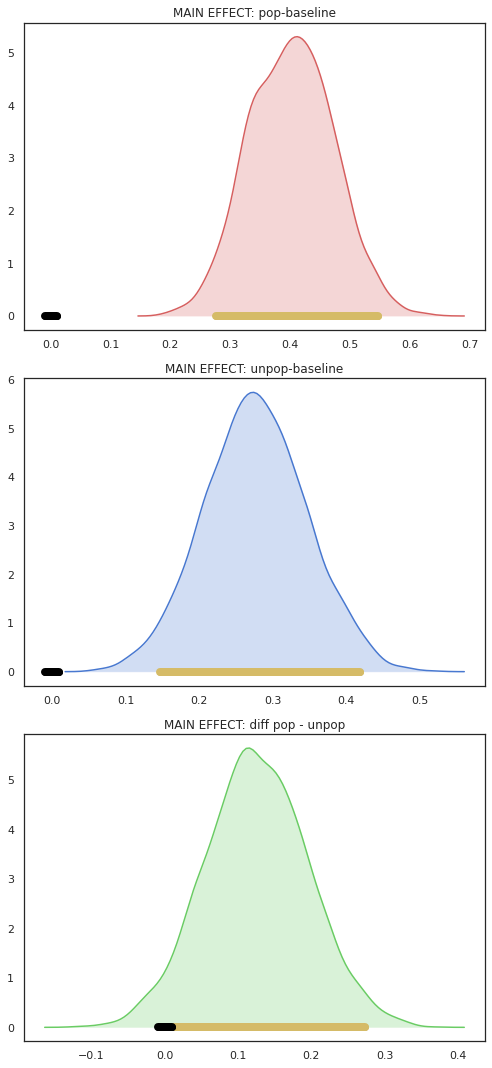

In [52]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

fit_df_2 = fit_3dprime_interaction_full.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=129
NxWithinLvl=3
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxW = np.zeros((NxSubjectLvl, NxWithinLvl, NxSamples))
mSxBxW = np.zeros((NxSubjectLvl, 2, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(2): #order effects
            exec('mu = fit_df_2["a0"] + fit_df_2["aCondition[{}]"] + fit_df_2["aS[{}]"]+fit_df_2["orderv[{}]"]'.format(i+1,k+1,j+1))
            mSxBxW[k,j,i,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
print('ms shape')
print(mS.data.shape)

# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
print('mBxW shape')
print(mBxW.data.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
print('mb shape')
print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
# print('mw shape')
# print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
print('bB shape')
print(bB.shape)

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()
print('mB squeeze')
print(mB.squeeze()[1:10])
print('bS shape')
print(bS.shape)

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

group1=bB[0,:]
group2=bB[1,:]

base1 = bBxW[0,0,:]
pop1 = bBxW[0,1,:]
unpop1 = bBxW[0,2,:]
diff_order1=pop1-unpop1

base2 = bBxW[1,0,:]
pop2 = bBxW[1,1,:]
unpop2 = bBxW[1,2,:]
diff_order2=pop2-unpop2

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

rope=0.01

z=0
for i in mdiff_pop_unpop1:
    if i>rope:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(mdiff_pop_unpop1))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)
ml_e, mr_e = highest_density_interval(diff_order1)
ml_f, mr_f = highest_density_interval(diff_order2)



sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(3, 1, figsize=(7, 15),sharex=False)

ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax1=sns.distplot(diff_order1, hist=False,kde_kws={"shade": True},color="g", ax=axs[3])
# ax1.set(title='order 1: diff pop - unpop',xlabel='')

# axs[3].plot([ml_e, mr_e],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax1=sns.distplot(diff_order2, hist=False,kde_kws={"shade": True},color="g", ax=axs[4])
# ax1.set(title='order 2: diff pop - unpop',xlabel='')

# axs[4].plot([ml_f, mr_f],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


plt.tight_layout()
plt.show()


# Status model contrasts on subjects who knew peers (n=96)

ms shape
(96, 2, 4000)
mBxW shape
(2, 3, 4000)
mb shape
(2, 1, 4000)
bB shape
(2, 4000)
mB squeeze
[[2.11929321 2.19006455 1.9575383  ... 1.91614694 2.00908375 1.79093737]]
bS shape
(96, 2, 4000)
percentage of parameters above 0 = 0.98025



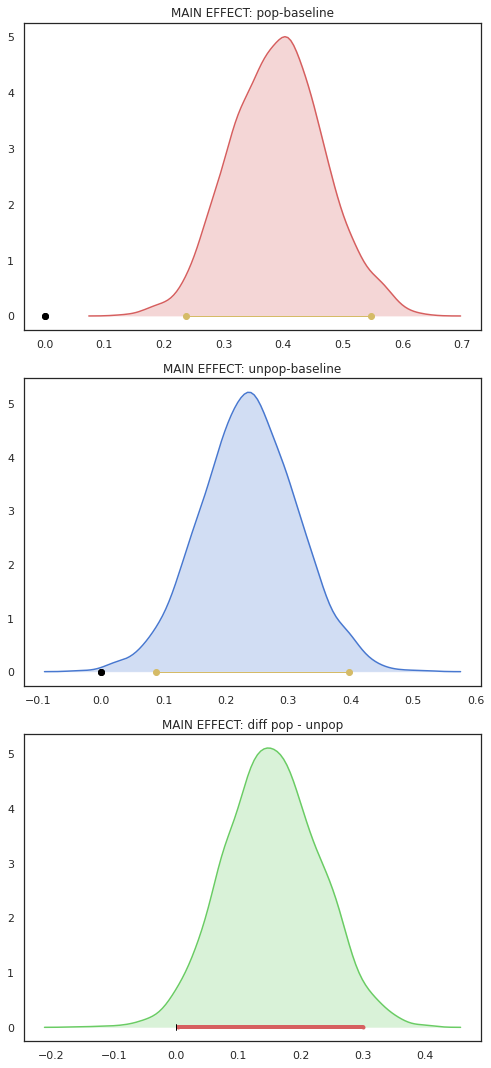

In [75]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

fit_df_2 = fit_3dprime_interaction_red.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=96
NxWithinLvl=3
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxW = np.zeros((NxSubjectLvl, NxWithinLvl, NxSamples))
mSxBxW = np.zeros((NxSubjectLvl, 2, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(2): #order effects
            exec('mu = fit_df_2["a0"] + fit_df_2["aCondition[{}]"] + fit_df_2["aS[{}]"]+fit_df_2["orderv[{}]"]'.format(i+1,k+1,j+1))
            mSxBxW[k,j,i,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
print('ms shape')
print(mS.data.shape)

# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
print('mBxW shape')
print(mBxW.data.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
print('mb shape')
print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
# print('mw shape')
# print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
print('bB shape')
print(bB.shape)

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()
print('mB squeeze')
print(mB.squeeze()[1:10])
print('bS shape')
print(bS.shape)

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

group1=bB[0,:]
group2=bB[1,:]

base1 = bBxW[0,0,:]
pop1 = bBxW[0,1,:]
unpop1 = bBxW[0,2,:]
diff_order1=pop1-unpop1

base2 = bBxW[1,0,:]
pop2 = bBxW[1,1,:]
unpop2 = bBxW[1,2,:]
diff_order2=pop2-unpop2

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

rope=0

z=0
for i in mdiff_pop_unpop1:
    if i>rope:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(mdiff_pop_unpop1))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)
ml_e, mr_e = highest_density_interval(diff_order1)
ml_f, mr_f = highest_density_interval(diff_order2)



sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(3, 1, figsize=(7, 15),sharex=False)

ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=1.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=1.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=1.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=1.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=4.0,label='95% HDI',marker='.',color='r')
axs[2].plot([-rope, rope],[0,0],linewidth=10.0,label='ROPE',marker='|',color='black')

# ax1=sns.distplot(diff_order1, hist=False,kde_kws={"shade": True},color="g", ax=axs[3])
# ax1.set(title='order 1: diff pop - unpop',xlabel='')

# axs[3].plot([ml_e, mr_e],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax1=sns.distplot(diff_order2, hist=False,kde_kws={"shade": True},color="g", ax=axs[4])
# ax1.set(title='order 2: diff pop - unpop',xlabel='')

# axs[4].plot([ml_f, mr_f],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


plt.tight_layout()
plt.show()


# Compute contrasts and visualize results for Individual Value model

ms shape
(129, 3, 4000)
mO shape
(3, 2, 4000)
mBxW shape
(3, 3, 4000)
mb shape
(3, 1, 4000)
mw shape
(1, 3, 4000)
Mean baseline yield: 1.9998262431144518
b0 shape
(4000,)
bW shape
(3, 4000)
bS shape
(129, 3, 4000)
bO shape
(3, 2, 4000)
percentage of parameters above 0 = 0.97225



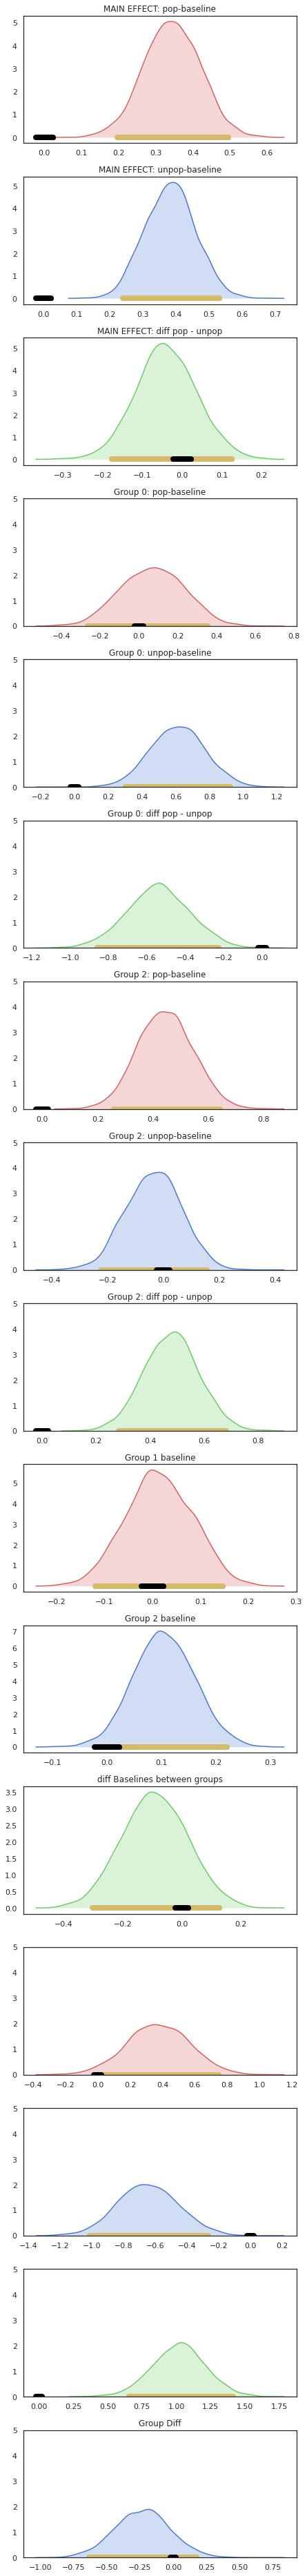

In [44]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy.ma as ma
import numpy as np


font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 40}

matplotlib.rc('font', **font)

fit_df_2 = fit_3dprime_interaction_full_three.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=129
NxBetweenLvl=3
NxWithinLvl=3
NxOrder=2
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxBxWxO = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl,NxOrder,NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(NxBetweenLvl):
            for o in range(NxOrder):
                exec('mu = fit_df_2["a0"]+ fit_df_2["aGroup[{}]"] + fit_df_2["aCondition[{}]"] + fit_df_2["aInteraction[{},{}]"] + fit_df_2["aS[{}]"]+fit_df_2["orderv[{}]"]'.format(j+1,i+1,i+1,j+1,k+1,o+1))
                mSxBxWxO[k,j,i,o,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxWxO, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mSo = ma.mean(mSxBxW_ma, axis=(2))
mS = ma.mean(mSo,axis=(2))
mO = ma.mean(mSo,axis=(0))
print('ms shape')
print(mS.shape)

print('mO shape')
print(mO.shape)

# Mean for treatment combination BxW, across subjects S
mBxWxO = mSxBxW_ma.mean(axis=(0))
mBxW=mBxWxO.mean(axis=(2))
print('mBxW shape')
print(mBxW.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
print('mb shape')
print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
print('mw shape')
print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
print('Mean baseline yield: {}'.format(b0.mean()))
print('b0 shape')
print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m
print('bW shape')
print(bW.data.shape)

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()
print('bS shape')
print(bS.shape)

bO = mO.squeeze() - m
print('bO shape')
print(bO.shape)

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

group1=bB[0,:]
group2=bB[1,:]
group3=bB[2,:]

base1 = bBxW[0,0,:]
pop1 = bBxW[0,1,:]
unpop1 = bBxW[0,2,:]

pop_dBase1 = (pop1+mpop1)-(base1+mbase1)
unpop_dBase1 = (munpop1+unpop1)-(base1+mbase1)
diff_pop_unpop1 = pop_dBase1-unpop_dBase1

base2 = bBxW[2,0,:]
pop2 = bBxW[2,1,:]
unpop2 = bBxW[2,2,:]

pop_dBase2 = (pop2+mpop1)-(base2+mbase1)
unpop_dBase2 = (munpop1+unpop2)-(base2+mbase1)
diff_pop_unpop2 = pop_dBase2-unpop_dBase2
diff_base=(base1+mbase1)-(base2+mbase1)


base_eq = bBxW[1,0,:]
pop_eq = bBxW[1,1,:]
unpop_eq = bBxW[1,2,:]

pop_dBaseE = (pop_eq+mpop1)-(base_eq+mbase1)
unpop_dBaseE = (munpop1+unpop_eq)-(base_eq+mbase1)
diff_pop_unpopE = pop_dBaseE-unpop_dBaseE

pop_diff=pop_dBase2-pop_dBase1
unpop_diff=unpop_dBase2-unpop_dBase1
diff_effect=diff_pop_unpop2-diff_pop_unpop1
group_diff=group1-group2
z=0
for i in pop_diff:
    if i>0:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(pop_diff))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)

l_ct, r_ct = highest_density_interval(pop_dBase1)
l_cp, r_cp = highest_density_interval(unpop_dBase1)
l_d, r_d = highest_density_interval(diff_pop_unpop1)

hl_ct, hr_ct = highest_density_interval(pop_dBase2)
hl_cp, hr_cp = highest_density_interval(unpop_dBase2)
hl_d, hr_d = highest_density_interval(diff_pop_unpop2)
hl_dr, hr_dr = highest_density_interval(diff_base)
lf,bf = highest_density_interval(base1)
la,ba= highest_density_interval(base2)


zhl_ct, zhr_ct = highest_density_interval(pop_diff)
zhl_cp, zhr_cp = highest_density_interval(unpop_diff)
zhl_cr, zhr_cr = highest_density_interval(diff_effect)

zhl_cf, zhr_cf = highest_density_interval(group_diff)

rope=0.023

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(16, 1, figsize=(6.2, 52),sharex=False)


ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(pop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[3])
ax0.set(title='Group 0: pop-baseline',xlabel='')

axs[3].plot([l_ct, r_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[3].set_ylim([0, 5])
axs[3].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(unpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[4])
ax1.set(title='Group 0: unpop-baseline',xlabel='')

axs[4].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[4].set_ylim([0, 5])
axs[4].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(diff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[5])
ax1.set(title='Group 0: diff pop - unpop',xlabel='')

axs[5].plot([l_d, r_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[5].set_ylim([0, 5])
axs[5].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(pop_dBase2, hist=False,kde_kws={"shade": True},color="r", ax=axs[6])
ax0.set(title='Group 2: pop-baseline',xlabel='')


axs[6].plot([hl_ct, hr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[6].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[6].set_ylim([0, 5])
axs[6].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(unpop_dBase2, hist=False,kde_kws={"shade": True},color="b", ax=axs[7])
ax1.set(title='Group 2: unpop-baseline',xlabel='')

axs[7].plot([hl_cp, hr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[7].set_ylim([0, 5])
axs[7].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(diff_pop_unpop2, hist=False,kde_kws={"shade": True},color="g", ax=axs[8])
ax1.set(title='Group 2: diff pop - unpop',xlabel='')

axs[8].plot([hl_d, hr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[8].set_ylim([0, 5])
axs[8].set_yticks(np.linspace(0,5,6))


ax0=sns.distplot(base1, hist=False,kde_kws={"shade": True},color="r", ax=axs[9])
ax0.set(title='Group 1 baseline',xlabel='')

axs[9].plot([lf, bf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[9].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(base2, hist=False,kde_kws={"shade": True},color="b", ax=axs[10])
ax1.set(title='Group 2 baseline',xlabel='')

axs[10].plot([la, ba],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[10].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_base, hist=False,kde_kws={"shade": True},color="g", ax=axs[11])
ax1.set(title='diff Baselines between groups',xlabel='')

axs[11].plot([hl_dr, hr_dr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[11].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')



ax0=sns.distplot(pop_diff, hist=False,kde_kws={"shade": True},color="r", ax=axs[12])
# ax0.set(title='Group 2 - Group 1 on Popular',xlabel='')

axs[12].plot([zhl_ct, zhr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[12].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[12].set_ylim([0, 5])
axs[12].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(unpop_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[13])
# ax0.set(title='Group 2 - Group 1 on Unpopular',xlabel='')

axs[13].plot([zhl_cp, zhr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[13].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[13].set_ylim([0, 5])
axs[13].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(diff_effect, hist=False,kde_kws={"shade": True},color="g", ax=axs[14])
# ax0.set(title='Group 2 - Group 1 on Effect of Popularity',xlabel='')

axs[14].plot([zhl_cr, zhr_cr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[14].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axs[14].set_ylim([0, 5])
axs[14].set_yticks(np.linspace(0,5,6))
ax1=sns.distplot(group_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[15])
ax1.set(title='Group Diff',xlabel='')

axs[15].plot([zhl_cf, zhr_cf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[15].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[15].set_ylim([0, 5])
axs[15].set_yticks(np.linspace(0,5,6))

plt.tight_layout()
plt.show()


percentage of parameters above 0 = 0.991



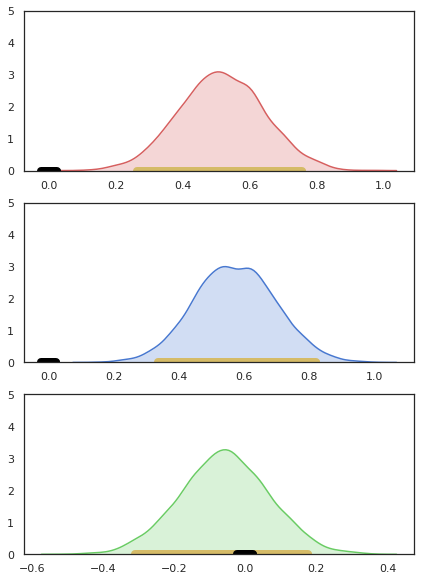

In [37]:



pop_diff2=pop_dBaseE-pop_dBase1
unpop_diff2=unpop_dBaseE-unpop_dBase1
diff_effect2=diff_pop_unpopE-diff_pop_unpop1

ml_c, mr_c = highest_density_interval(pop_diff2)
ml_r, mr_r = highest_density_interval(unpop_diff2)
ml_, mr_ = highest_density_interval(diff_effect2)
z=0
for i in diff_effect2:
    if i>rope:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(diff_effect2))))
print('')

f, axs = plt.subplots(3, 1, figsize=(7, 10),sharex=False)

# ax0=sns.distplot(pop_diff2, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
# # ax0.set(title=' No Pref vs. Low pref: high-baseline',xlabel='')

# axs[0].plot([ml_c, mr_c],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax0=sns.distplot(unpop_diff2, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
# ax0.set(title='No Pref vs. Low pref: low-baseline',xlabel='')

# axs[1].plot([ml_r, mr_r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax0=sns.distplot(diff_effect2, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
# ax0.set(title='No Pref vs. Low pref: high-low',xlabel='')

# axs[2].plot([ml_, mr_],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# pop_diff3=pop_dBase2-pop_dBaseE
# unpop_diff3=unpop_dBase2-unpop_dBaseE
# diff_effect3=diff_pop_unpop2-diff_pop_unpopE

# ml_p, mr_p = highest_density_interval(pop_diff3)
# ml_f, mr_f = highest_density_interval(unpop_diff3)
# ml_x, mr_x = highest_density_interval(diff_effect3)


# ax0=sns.distplot(pop_diff3, hist=False,kde_kws={"shade": True},color="r", ax=axs[3])
# ax0.set(title=' No Pref vs. High pref: high-baseline',xlabel='')

# axs[3].plot([ml_p, mr_p],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax0=sns.distplot(unpop_diff3, hist=False,kde_kws={"shade": True},color="b", ax=axs[4])
# ax0.set(title='No Pref vs. High pref: low-baseline',xlabel='')

# axs[4].plot([ml_f, mr_f],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax0=sns.distplot(diff_effect3, hist=False,kde_kws={"shade": True},color="g", ax=axs[5])
# ax0.set(title='No Pref vs. High pref: high-low',xlabel='')

# axs[5].plot([ml_x, mr_x],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

pop_diffE=pop_dBaseE
unpop_diffE=unpop_dBaseE
diff_effectE=diff_pop_unpopE

ml_q, mr_q = highest_density_interval(pop_diffE)
ml_l, mr_l = highest_density_interval(unpop_diffE)
ml_v, mr_v = highest_density_interval(diff_effectE)


ax0=sns.distplot(pop_diffE, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
# ax0.set(title=' No Pref: high-baseline',xlabel='')

axs[0].plot([ml_q, mr_q],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[0].set_ylim([0, 5])
axs[0].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(unpop_diffE, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
# ax0.set(title='No Pref: low-baseline',xlabel='')

axs[1].plot([ml_l, mr_l],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[1].set_ylim([0, 5])
axs[1].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(diff_effectE, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
# ax0.set(title='No Pref: high-low',xlabel='')

axs[2].plot([ml_v, mr_v],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[2].set_ylim([0, 5])
axs[2].set_yticks(np.linspace(0,5,6))

font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 40}

matplotlib.rc('font', **font)
plt.ylim(0,5)
plt.show()

# Individual value model contrasts: only known subs (n=96)

ms shape
(96, 3, 4000)
mO shape
(3, 2, 4000)
mBxW shape
(3, 3, 4000)
mb shape
(3, 1, 4000)
mw shape
(1, 3, 4000)
Mean baseline yield: 1.9814710976984204
b0 shape
(4000,)
bW shape
(3, 4000)
bS shape
(96, 3, 4000)
bO shape
(3, 2, 4000)
percentage of parameters above 0 = 0.93525



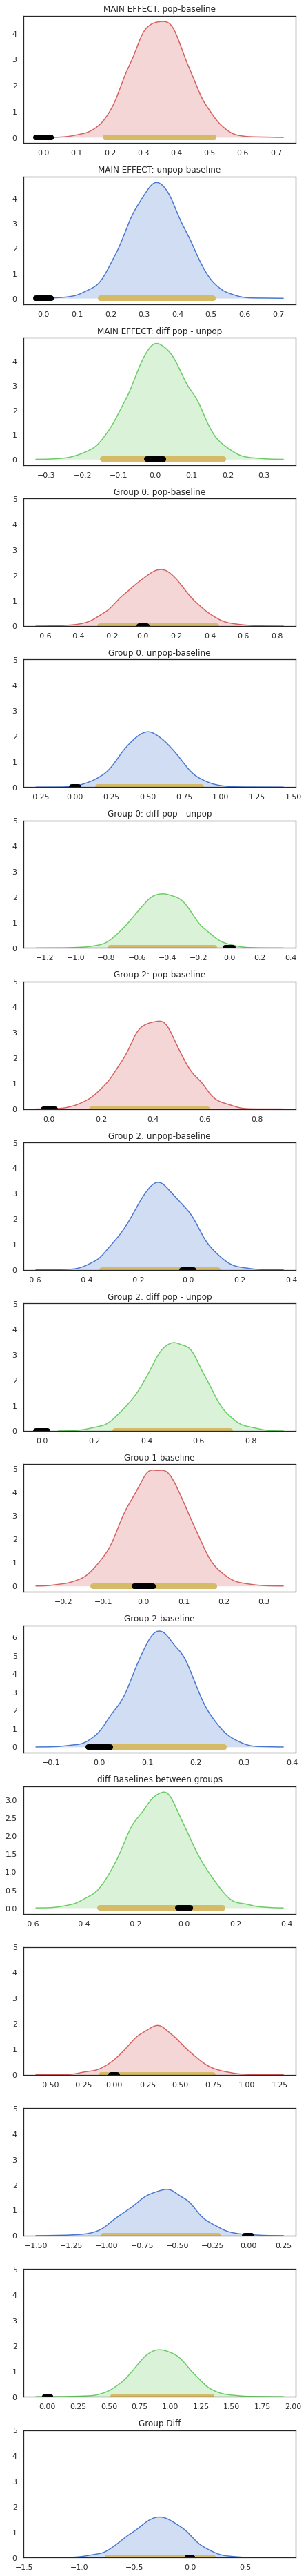

In [69]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy.ma as ma
import numpy as np


font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 40}

matplotlib.rc('font', **font)

fit_df_2 = fit_3dprime_interaction_red_three.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=96
NxBetweenLvl=3
NxWithinLvl=3
NxOrder=2
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxBxWxO = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl,NxOrder,NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(NxBetweenLvl):
            for o in range(NxOrder):
                exec('mu = fit_df_2["a0"]+ fit_df_2["aGroup[{}]"] + fit_df_2["aCondition[{}]"] + fit_df_2["aInteraction[{},{}]"] + fit_df_2["aS[{}]"]+fit_df_2["orderv[{}]"]'.format(j+1,i+1,i+1,j+1,k+1,o+1))
                mSxBxWxO[k,j,i,o,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxWxO, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mSo = ma.mean(mSxBxW_ma, axis=(2))
mS = ma.mean(mSo,axis=(2))
mO = ma.mean(mSo,axis=(0))
print('ms shape')
print(mS.shape)

print('mO shape')
print(mO.shape)

# Mean for treatment combination BxW, across subjects S
mBxWxO = mSxBxW_ma.mean(axis=(0))
mBxW=mBxWxO.mean(axis=(2))
print('mBxW shape')
print(mBxW.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
print('mb shape')
print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
print('mw shape')
print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
print('Mean baseline yield: {}'.format(b0.mean()))
print('b0 shape')
print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m
print('bW shape')
print(bW.data.shape)

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()
print('bS shape')
print(bS.shape)

bO = mO.squeeze() - m
print('bO shape')
print(bO.shape)

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

group1=bB[0,:]
group2=bB[1,:]
group3=bB[2,:]

base1 = bBxW[0,0,:]
pop1 = bBxW[0,1,:]
unpop1 = bBxW[0,2,:]

pop_dBase1 = (pop1+mpop1)-(base1+mbase1)
unpop_dBase1 = (munpop1+unpop1)-(base1+mbase1)
diff_pop_unpop1 = pop_dBase1-unpop_dBase1

base2 = bBxW[2,0,:]
pop2 = bBxW[2,1,:]
unpop2 = bBxW[2,2,:]

pop_dBase2 = (pop2+mpop1)-(base2+mbase1)
unpop_dBase2 = (munpop1+unpop2)-(base2+mbase1)
diff_pop_unpop2 = pop_dBase2-unpop_dBase2
diff_base=(base1+mbase1)-(base2+mbase1)


base_eq = bBxW[1,0,:]
pop_eq = bBxW[1,1,:]
unpop_eq = bBxW[1,2,:]

pop_dBaseE = (pop_eq+mpop1)-(base_eq+mbase1)
unpop_dBaseE = (munpop1+unpop_eq)-(base_eq+mbase1)
diff_pop_unpopE = pop_dBaseE-unpop_dBaseE

pop_diff=pop_dBase2-pop_dBase1
unpop_diff=unpop_dBase2-unpop_dBase1
diff_effect=diff_pop_unpop2-diff_pop_unpop1
group_diff=group1-group2
z=0
for i in pop_diff:
    if i>0:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(pop_diff))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)

l_ct, r_ct = highest_density_interval(pop_dBase1)
l_cp, r_cp = highest_density_interval(unpop_dBase1)
l_d, r_d = highest_density_interval(diff_pop_unpop1)

hl_ct, hr_ct = highest_density_interval(pop_dBase2)
hl_cp, hr_cp = highest_density_interval(unpop_dBase2)
hl_d, hr_d = highest_density_interval(diff_pop_unpop2)
hl_dr, hr_dr = highest_density_interval(diff_base)
lf,bf = highest_density_interval(base1)
la,ba= highest_density_interval(base2)


zhl_ct, zhr_ct = highest_density_interval(pop_diff)
zhl_cp, zhr_cp = highest_density_interval(unpop_diff)
zhl_cr, zhr_cr = highest_density_interval(diff_effect)

zhl_cf, zhr_cf = highest_density_interval(group_diff)

rope=0.023

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(16, 1, figsize=(6.2, 52),sharex=False)


ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(pop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[3])
ax0.set(title='Group 0: pop-baseline',xlabel='')

axs[3].plot([l_ct, r_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[3].set_ylim([0, 5])
axs[3].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(unpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[4])
ax1.set(title='Group 0: unpop-baseline',xlabel='')

axs[4].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[4].set_ylim([0, 5])
axs[4].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(diff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[5])
ax1.set(title='Group 0: diff pop - unpop',xlabel='')

axs[5].plot([l_d, r_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[5].set_ylim([0, 5])
axs[5].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(pop_dBase2, hist=False,kde_kws={"shade": True},color="r", ax=axs[6])
ax0.set(title='Group 2: pop-baseline',xlabel='')


axs[6].plot([hl_ct, hr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[6].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[6].set_ylim([0, 5])
axs[6].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(unpop_dBase2, hist=False,kde_kws={"shade": True},color="b", ax=axs[7])
ax1.set(title='Group 2: unpop-baseline',xlabel='')

axs[7].plot([hl_cp, hr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[7].set_ylim([0, 5])
axs[7].set_yticks(np.linspace(0,5,6))

ax1=sns.distplot(diff_pop_unpop2, hist=False,kde_kws={"shade": True},color="g", ax=axs[8])
ax1.set(title='Group 2: diff pop - unpop',xlabel='')

axs[8].plot([hl_d, hr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[8].set_ylim([0, 5])
axs[8].set_yticks(np.linspace(0,5,6))


ax0=sns.distplot(base1, hist=False,kde_kws={"shade": True},color="r", ax=axs[9])
ax0.set(title='Group 1 baseline',xlabel='')

axs[9].plot([lf, bf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[9].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(base2, hist=False,kde_kws={"shade": True},color="b", ax=axs[10])
ax1.set(title='Group 2 baseline',xlabel='')

axs[10].plot([la, ba],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[10].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_base, hist=False,kde_kws={"shade": True},color="g", ax=axs[11])
ax1.set(title='diff Baselines between groups',xlabel='')

axs[11].plot([hl_dr, hr_dr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[11].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')



ax0=sns.distplot(pop_diff, hist=False,kde_kws={"shade": True},color="r", ax=axs[12])
# ax0.set(title='Group 2 - Group 1 on Popular',xlabel='')

axs[12].plot([zhl_ct, zhr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[12].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[12].set_ylim([0, 5])
axs[12].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(unpop_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[13])
# ax0.set(title='Group 2 - Group 1 on Unpopular',xlabel='')

axs[13].plot([zhl_cp, zhr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[13].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[13].set_ylim([0, 5])
axs[13].set_yticks(np.linspace(0,5,6))

ax0=sns.distplot(diff_effect, hist=False,kde_kws={"shade": True},color="g", ax=axs[14])
# ax0.set(title='Group 2 - Group 1 on Effect of Popularity',xlabel='')

axs[14].plot([zhl_cr, zhr_cr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[14].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axs[14].set_ylim([0, 5])
axs[14].set_yticks(np.linspace(0,5,6))
ax1=sns.distplot(group_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[15])
ax1.set(title='Group Diff',xlabel='')

axs[15].plot([zhl_cf, zhr_cf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[15].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')
axs[15].set_ylim([0, 5])
axs[15].set_yticks(np.linspace(0,5,6))

plt.tight_layout()
plt.show()
